In [12]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from balanced_kmeans import kmeans_equal

# from scipy.optimize import least_squares, minimize
# import jax.numpy.linalg as npl
# import jax.numpy as np
# from jax import grad, jit
import torch
from torch import nn


In [13]:
class MTL(nn.Module):
    def __init__(self,d,R,T):
        super(MTL, self).__init__()
        self.linear=nn.Linear(d,R,bias=False)
        self.heads=nn.ModuleList([nn.Linear(R,1,bias=False) for _ in range(T)])
    def forward(self, x, task_id):
        return self.heads[task_id](self.linear(x))

class CMTL(nn.Module):
    def __init__(self,d,r,K,T):
        super(CMTL, self).__init__()
        self.clusters=nn.ModuleList([nn.Linear(d,r,bias=False) for _ in range(K)])
        self.heads=nn.ModuleList([nn.Linear(r,1,bias=False) for _ in range(T)])
        self.PCID=None
    def forward(self, x, task_id):
        if self.PCID is None:
            raise ValueError('PCID is None')
        return self.heads[task_id](self.clusters[self.PCID[task_id]](x))

class MPMTL(nn.Module):
    def __init__(self,d,R,r,K,T):
        super(MPMTL, self).__init__()
        self.linear=nn.Linear(d,R,bias=False)
        self.clusters=nn.ModuleList([nn.Linear(R,r,bias=False) for _ in range(K)])
        self.heads=nn.ModuleList([nn.Linear(r,1,bias=False) for _ in range(T)])
        self.PCID=None
    def forward(self, x, task_id):
        if self.PCID is None:
            raise ValueError('PCID is None')
        return self.heads[task_id](self.clusters[self.PCID[task_id]](self.linear(x)))

In [14]:
def quant(x,c):
    return np.quantile(x,c,1)
def get_sub(r,d):
    return npl.svd(np.random.randn(r,d))[2][:r]
def randn_norm(T,r):
    X=np.random.randn(T,r)
    return np.array([X[i]/npl.norm(X[i]) for i in range(T)])

def eig_R(X,r):
    SH,V,_=npl.svd(X)
    return SH[:,:r].T,np.diag(V[:r])

def cluster_algo(n_clusters, W, CID):
    clustering=KMeans(n_clusters=K,n_init=100,tol=1e-4).fit(W.abs())
    PCID,acc=reorder(clustering.labels_,CID)
    return PCID,acc

def reorder(PCID,CID):
    for i in range(K):
        ip=np.quantile(PCID[np.where(CID==i)[0]],0.5)
        PCID[np.where(PCID==i)[0]]=-1
        PCID[np.where(PCID==ip)[0]]=i
        PCID[np.where(PCID==-1)[0]]=ip
    return PCID, (PCID==CID).sum()/len(CID)

def cluster_algo_v2(n_clusters, W, CID):
    W=np.abs(W)
    cluster_id=list(range(K))
    clustering=KMeans(n_clusters=K,n_init=10).fit(W)
    PCID=clustering.labels_
    _,acc=reorder(PCID,CID)
    # print(acc)
    
    j=0
    while j<100:
        j+=1
        cid=[]
        for i,c in enumerate(cluster_id):
            ids=np.where(PCID==c)[0]
            if len(ids)<k or len(ids)>k*1.1:
            # if len(ids)!=k:
                PCID[ids]=-1
                continue
            if len(ids)==k:
                cid.append(c)
                continue
            center=clustering.cluster_centers_[i]
            dist=npl.norm(center.reshape(1,-1)-W[ids].numpy().reshape(-1,K*k),axis=1)**2
            # score=npl.norm(np.quantile(dist,0.5).reshape(1,-1)-dist,axis=1)
            # print(ids, dist,score)
            PCID[ids[dist.argsort()[k:]]]=-1
            # print(PCID)
            cid.append(c)
        cluster_id=[id for id in cluster_id if id not in cid]
        if len(cluster_id) == 0:
            break
        clustering=KMeans(n_clusters=len(cluster_id),n_init=10).fit(W[np.where(PCID==-1)[0]])
        PCID[np.where(PCID==-1)[0]]=np.array(list(cluster_id))[clustering.labels_]
        
    
    PCID,acc=reorder(PCID,CID)
    return PCID,acc



def cluster_algo_v3(n_clusters, W, CID):
    W=np.abs(W)
    X=W.reshape(1,W.shape[0],W.shape[1])
    # print(W.shape)
    # W=torch.randn_like(W)
    # print(W.shape, n_clusters, W.shape[1]//n_clusters)
    PCID, centers = kmeans_equal(X, num_clusters=n_clusters, cluster_size=W.shape[0]//n_clusters)
    PCID = PCID[0].numpy()
    # print(PCID)
    def reorder_v2(PCID,CID):
        counter = np.zeros((n_clusters, n_clusters))
        for i in range(PCID.shape[0]):
            counter[PCID[i],CID[i]] += 1
        max_value = counter.max()
        id_map = [-1 for _ in range(n_clusters)]
        while max_value>=0:
            for i in range(n_clusters):
                for j in range(n_clusters):
                    if counter[i,j]==max_value and id_map[i] < 0 and j not in id_map:
                        id_map[i]=j
            max_value -= 1
        i = 0
        while max(id_map)>0:
            if id_map[i] < 0:
                i = (i+1)%n_clusters
                continue
            PCID[np.where(PCID==i)[0]]=-1
            PCID[np.where(PCID==id_map[i])[0]]=i
            PCID[np.where(PCID==-1)[0]]=id_map[i]
            temp = id_map[i]
            id_map[i]=id_map[temp]
            id_map[temp]=-1
        return PCID, (PCID==CID).sum()/len(CID)
    
    return reorder_v2(PCID, CID)

def do_one_iter():
    T=K*k
    ERR=10000*np.ones((2,3))
    accuracy=[0,0]
    while int(accuracy[0])!=1:
        SM=get_sub(R,d)
        SC=[]
        SCC=[]
        for i in range(K):
            SC.append(get_sub(r,R))
            SCC.append(SC[i].dot(SM))

        betas=randn_norm(T,r)
        betasD=torch.zeros((T,d))
        CID=np.array([i//k for i in range(T)])
        betaC=randn_norm(K,r)
        
        for i in range(K):
            THRED=0.
            for _ in range(20):
                w=randn_norm(k,r)*(1-GAMMA)+betaC[i].reshape(1,-1)*GAMMA
                w/=npl.norm(w,axis=1).reshape(-1,1)
                score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
                if score.min()>THRED:
                    THRED=score.min()
            # print(THRED)
            while True:
                w=randn_norm(k,r)*(1-GAMMA)+betaC[i].reshape(1,-1)*GAMMA
                w/=npl.norm(w,axis=1).reshape(-1,1)
                score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
                # print(score.min())
                if score.min()>THRED:
                    # print(i,score.min())
                    break
            for j, t in enumerate(np.where(CID==i)[0]):
                betas[t]=w[j]

        for t in range(T):
            betasD[t]=torch.from_numpy(np.asarray(SCC[CID[t]].T.dot(betas[t]))).float()
            
        Beta = betasD/torch.norm(betasD, dim=1).reshape(-1,1)
        PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta.mm(Beta.T),CID=CID)
        # PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta,CID=CID)
        print('oracle cluster acc', acc)
        accuracy[0]=acc

    yy=torch.zeros((T,n,1))
    XX=torch.randn(T,n,d)
    yt=torch.zeros((T,n,1))
    XT=torch.randn(T,n,d)
    betah=torch.zeros((T,d,1))
    for t in range(T):
        yy[t]=XX[t].mm(betasD[t].reshape(-1,1))+torch.sqrt(torch.tensor(sigma))*torch.randn(n,1)
        yt[t]=XT[t].mm(betasD[t].reshape(-1,1))+torch.sqrt(torch.tensor(sigma))*torch.randn(n,1)
        betah[t]=XX[t].T.mm(yy[t])/n
    # return None
    # return Beta.mm(Beta.T)
    # Moment-based MTL, C-MTL, MP-MTL initializations
    MOM=np.zeros((d,d))
    MOMT=[]
    for i in range(K):
        MOMT.append(np.zeros((d,d)))
        for t in np.where(CID==i)[0]:
            MOM+=np.outer(betah[t],betah[t])
            MOMT[i]+=np.outer(betah[t],betah[t])
        MOMT[i]/=len(np.where(CID==i)[0])
    MOM/=T

    HM,_=eig_R(MOM,R)
    HC=[]
    errsubT=0
    for i in range(K):
        MOMH,_=eig_R(MOMT[i],r)
        errsubT+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SCC[i].T.dot(SCC[i]))
        HC.append(MOMH)

    MOMC=[]
    MOMCC=[]
    errsubP=0
    for i in range(K):
        MOMC.append(HM.T.dot(HM).dot(MOMT[i]).dot(HM.T.dot(HM)))

    HPC=[]
    for i in range(K):
        MOMH,_=eig_R(MOMC[i],r)
        errsubP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))
        HPC.append(MOMH)

    HP=[]
    errsubPP=0
    for i in range(K):
        HP.append(HPC[i].dot(HM.T))
        MOMH=HP[i].dot(HM)
        errsubPP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))


    # Alternating LS for MTL variations 
    GM=HM.copy()
    GT=np.array(HC)
    beta=np.zeros((T,d))
    betaC=np.zeros((T,r))
    Beta = torch.zeros((T,d))
    beta_=np.zeros((T,R))
    ITN=1000
    # MTL ALS
    if RANDOM_CLUSTER is True:
        PCID = CID
        np.random.shuffle(PCID)
        acc=1.
    elif GROUND_TRUTH is True:
        PCID = CID
        acc=1.
    else:
        print('Start MTL ...')
        model=MTL(d=d,R=R,T=T)
        criterion=nn.MSELoss()
        optimizer=torch.optim.SGD(model.parameters(),lr=lr_mtl)#torch.sqrt(torch.tensor(float(n))))
        model.linear.weight.data=torch.from_numpy(np.asarray(GM)).float()
        model.train()
        for it in range(ITN):
            loss=0.
            for t in range(T):
                output=model(XX[t],t)
                loss+=criterion(output,yy[t])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # def closure():
            #     loss=0.
            #     for t in range(T):
            #         output=model(XX[t],t)
            #         loss+=criterion(output,yy[t])
            #     optimizer.zero_grad()
            #     loss.backward()
            #     return loss
            # optimizer.step(closure)
            # loss=closure().item()
            if (it+1)%20 == 0:
                print(f'it {it+1}, training loss={loss/T}')
                # if it > 200:
                #     optimizer.param_groups[0]['lr']/=10
                # with torch.no_grad():
                #     u,D,vt=torch.svd(model.linear.weight)
                #     model.linear.weight.data=vt.T
                #     for t in range(T):
                #         model.heads[t].weight.data=model.heads[t].weight.data.mm(u).mm(torch.diag(D))
            if loss/T<eps:
                break

        model.eval()
        loss_train=0
        loss_test=0
        with torch.no_grad():
            for t in range(T):
                output=model(XX[t],t)
                loss_train+=criterion(output,yy[t])
                output=model(XT[t],t)
                loss_test+=criterion(output,yt[t])  
        ERR[0,0]=loss_train/T
        ERR[1,0]=loss_test/T
        print(ERR[0,0],ERR[1,0])

        # Beta = betasD/npl.norm(betasD, axis=1).reshape(-1,1)
        # Beta = (beta/npl.norm(beta,axis=1).reshape(-1,1)).copy()
        for t in range(T):
            bt=model.linear.weight.data.T.mm(model.heads[t].weight.data.T).reshape(-1)
            Beta[t]=bt/torch.norm(bt)
        PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta.mm(Beta.T), CID=CID)
        # PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta, CID=CID)
        print('cluster acc', acc)
        accuracy[1]=acc
        
        # print('PCID', PCID)
        # print('CID',CID)
        # print(np.abs(Beta.dot(Beta.T)))
    return ERR, acc
    # ITN=0
    # C-MTL ALS
    print('Start CMTL ...')
    model=CMTL(d=d,r=r,K=K,T=T)
    model.PCID=PCID
    criterion=nn.MSELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=lr_cmtl*acc)
    for i in range(K):
        model.clusters[i].weight.data=torch.from_numpy(np.asarray(GT[i])).float()
    model.train()
    for it in range(ITN):
        loss=0.
        for t in range(T):
            output=model(XX[t],t)
            loss+=criterion(output,yy[t])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (it+1)%20 == 0:
            print(f'it {it+1}, training loss={loss/T}')
            ## 
            # with torch.no_grad():
            #     for i in range(K):
            #         u_,D_,vt_=torch.svd(model.clusters[i].weight.data)
            #         model.clusters[i].weight.data=vt_.T
            #         for t in np.where(model.PCID==i)[0]:
            #             model.heads[t].weight.data=model.heads[t].weight.data.mm(u_).mm(torch.diag(D_))
            ##
        if loss/T<eps:
            break
    model.eval()
    loss_train=0
    loss_test=0
    with torch.no_grad():
        for t in range(T):
            output=model(XX[t],t)
            loss_train+=criterion(output,yy[t])
            output=model(XT[t],t)
            loss_test+=criterion(output,yt[t])  
    ERR[0,1]=loss_train/T
    ERR[1,1]=loss_test/T
    print(ERR[0,1],ERR[1,1])

    
    # ITN=0
    # MP-MTL ALS
    print('Start MP-MTL ...')
    GP=np.array(HP)
    GPM=HM.copy()
    model=MPMTL(d=d,R=R,r=r,K=K,T=T)
    model.PCID=PCID
    criterion=nn.MSELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=lr_mpmtl*acc)
    model.linear.weight.data=torch.from_numpy(np.asarray(GPM)).float()
    for i in range(K):
        model.clusters[i].weight.data=torch.from_numpy(np.asarray(GP[i])).float()
    model.train()
    for it in range(ITN):
        loss=0.
        for t in range(T):
            output=model(XX[t],t)
            loss+=criterion(output,yy[t])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (it+1)%20 == 0:
            print(f'it {it+1}, training loss={loss/T}')
            # if it > 100:
                # optimizer.param_groups[0]['lr']/=10
            # with torch.no_grad():
            #     u,D,vt=torch.svd(model.linear.weight.data)
            #     model.linear.weight.data=vt.T
            #     for i in range(K):
            #         model.clusters[i].weight.data= model.clusters[i].weight.data.mm(u).mm(torch.diag(D))
            #         u_,D_,vt_=torch.svd(model.clusters[i].weight.data)
            #         model.clusters[i].weight.data=vt_.T
            #         for t in np.where(model.PCID==i)[0]:
            #             model.heads[t].weight.data=model.heads[t].weight.data.mm(u_).mm(torch.diag(D_))
        if loss/T<eps:
            break
    model.eval()
    loss_train=0
    loss_test=0
    with torch.no_grad():
        for t in range(T):
            output=model(XX[t],t)
            loss_train+=criterion(output,yy[t])
            output=model(XT[t],t)
            loss_test+=criterion(output,yt[t])  
    ERR[0,2]=loss_train/T
    ERR[1,2]=loss_test/T
    print(ERR[0,2],ERR[1,2])
    return ERR, acc

def cluster_sep():
    T=K*k
    ERR=10000*np.ones((2,3))
    accuracy=[0,0]
    while int(accuracy[0])!=1:
        SM=get_sub(R,d)
        SC=[]
        SCC=[]
        for i in range(K):
            SC.append(get_sub(r,R))
            SCC.append(SC[i].dot(SM))

        betas=randn_norm(T,r)
        betasD=torch.zeros((T,d))
        CID=np.array([i//k for i in range(T)])
        betaC=randn_norm(K,r)
        
        for i in range(K):
            THRED=0.
            for _ in range(20):
                w=randn_norm(k,r)*(1-GAMMA)+betaC[i].reshape(1,-1)*GAMMA
                w/=npl.norm(w,axis=1).reshape(-1,1)
                score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
                if score.min()>THRED:
                    THRED=score.min()
            # print(THRED)
            while True:
                w=randn_norm(k,r)*(1-GAMMA)+betaC[i].reshape(1,-1)*GAMMA
                w/=npl.norm(w,axis=1).reshape(-1,1)
                score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
                # print(score.min())
                if score.min()>THRED:
                    # print(i,score.min())
                    break
            for j, t in enumerate(np.where(CID==i)[0]):
                betas[t]=w[j]

        for t in range(T):
            betasD[t]=torch.from_numpy(np.asarray(SCC[CID[t]].T.dot(betas[t]))).float()
            
        Beta = betasD/torch.norm(betasD, dim=1).reshape(-1,1)
        PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta.mm(Beta.T),CID=CID)
        # PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta,CID=CID)
        print('oracle cluster acc', acc)
        accuracy[0]=acc

    yy=torch.zeros((T,n,1))
    XX=torch.randn(T,n,d)
    yt=torch.zeros((T,n,1))
    XT=torch.randn(T,n,d)
    betah=torch.zeros((T,d,1))
    for t in range(T):
        yy[t]=XX[t].mm(betasD[t].reshape(-1,1))+torch.sqrt(torch.tensor(sigma))*torch.randn(n,1)
        yt[t]=XT[t].mm(betasD[t].reshape(-1,1))+torch.sqrt(torch.tensor(sigma))*torch.randn(n,1)
        betah[t]=XX[t].T.mm(yy[t])/n
    # return None
    # return Beta.mm(Beta.T)
    # Moment-based MTL, C-MTL, MP-MTL initializations
    MOM=np.zeros((d,d))
    MOMT=[]
    for i in range(K):
        MOMT.append(np.zeros((d,d)))
        for t in np.where(CID==i)[0]:
            MOM+=np.outer(betah[t],betah[t])
            MOMT[i]+=np.outer(betah[t],betah[t])
        MOMT[i]/=len(np.where(CID==i)[0])
    MOM/=T

    HM,_=eig_R(MOM,R)
    HC=[]
    errsubT=0
    for i in range(K):
        MOMH,_=eig_R(MOMT[i],r)
        errsubT+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SCC[i].T.dot(SCC[i]))
        HC.append(MOMH)

    MOMC=[]
    MOMCC=[]
    errsubP=0
    for i in range(K):
        MOMC.append(HM.T.dot(HM).dot(MOMT[i]).dot(HM.T.dot(HM)))

    HPC=[]
    for i in range(K):
        MOMH,_=eig_R(MOMC[i],r)
        errsubP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))
        HPC.append(MOMH)

    HP=[]
    errsubPP=0
    for i in range(K):
        HP.append(HPC[i].dot(HM.T))
        MOMH=HP[i].dot(HM)
        errsubPP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))


    # Alternating LS for MTL variations 
    GM=HM.copy()
    GT=np.array(HC)
    beta=np.zeros((T,d))
    betaC=np.zeros((T,r))
    Beta = torch.zeros((T,d))
    beta_=np.zeros((T,R))
    ITN=1000
    # MTL ALS
    if RANDOM_CLUSTER is True:
        PCID = CID
        np.random.shuffle(PCID)
        acc=1.
    elif GROUND_TRUTH is True:
        PCID = CID
        acc=1.
    else:
        for t in range(T):
            # print(f'Start Task {t} ...')
            model=MTL(d=d,R=r,T=1)
            criterion=nn.MSELoss()
            optimizer=torch.optim.SGD(model.parameters(),lr=lr_mtl)#torch.sqrt(torch.tensor(float(n))))
            HM,_=eig_R(np.outer(betah[t],betah[t]),r)
            GM=HM.copy()
            model.linear.weight.data=torch.from_numpy(np.asarray(GM)).float()
            model.train()
            for it in range(ITN):
                output=model(XX[t],0)
                loss=criterion(output,yy[t])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # if (it+1)%20 == 0:
                #     print(f'it {it+1}, training loss={loss/T}')
                if loss/T<eps:
                    break

            model.eval()
            bt=model.linear.weight.data.T.mm(model.heads[0].weight.data.T).reshape(-1)
            Beta[t]=bt/torch.norm(bt)

        PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta.mm(Beta.T), CID=CID)
        # PCID,acc=cluster_algo_v3(n_clusters=K, W=Beta, CID=CID)
        print('cluster acc', acc)
        accuracy[1]=acc
        
        # print('PCID', PCID)
        # print('CID',CID)
        # print(np.abs(Beta.dot(Beta.T)))
    return ERR, acc



In [15]:
lr_mtl=1e-2
lr_cmtl=1e-2
lr_mpmtl=1e-2
sigma=0.
eps=1e-5
GAMMA=0.6
THRED=0.
ITN=1 # NUMBER OF AVERAGES TO RUN
r=2
R=32
d=128
# n0=10
# nb=int(np.sqrt(R*r)*n0)
# kb=10
nb=40
Kb=50
kb=10
# T=Kb*k
LEN=10
# ns=(np.arange(LEN)+1)*10
ns=[10,20,30,40,50,60,70,80,90,100]
# ns=[10,20,30,40,50,60,80,100]
# ns=[10,20,25,30,35,40,50,60,70]
# ns=[10,20,30,35,40,45,50,60,80,100]
ks=[5,10,20]
Ks=[10,50,100]
# ns=[100,10]
# lrs=[0.001,0.0005]
# LEN=len(ks)
# Ks=[2,50]
# model_mtl=MTL(d=d,R=R,T=T)
# model_cmtl=CMTL(d=d,r=r,K=K,T=T)
# model_mpmtl=MPMTL(d=d,R=R,r=r,K=K,T=T)

# ##### ERRn
# ERRn=np.zeros((LEN,ITN,3,2,3))
# ERRk=np.zeros((LEN,ITN,3,2,3))
# ERRK=np.zeros((LEN,ITN,3,2,3))
# acc=np.zeros((LEN,ITN,1))
# print('Vary # samples')
# for it in range(ITN):
#     for x in range(LEN):
#         n=ns[x]; k=kb; K=Kb
#         print(n,k,K)
#         RANDOM_CLUSTER=False
#         GROUND_TRUTH = False
#         ERRn[x,it,0],acc[x,it]=do_one_iter()
#         GROUND_TRUTH = True
#         print(acc[x,it])
#         if acc[x,it] > .999:
#             ERRn[x,it,1] = ERRn[x,it,0].copy()
#         else:
#             ERRn[x,it,1],_=do_one_iter()
#         # RANDOM_CLUSTER = True
#         # ERRn[x,it,2],_=do_one_iter()
#     np.save(f'pytorch_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}GAMMA{GAMMA}try1.npy',ERRn)
#     np.save(f'pytorch_n_acc_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}GAMMA{GAMMA}try1.npy',acc)

##### acc
acc_k=np.zeros((LEN,ITN,len(ks),1))
print('Vary # samples')
for it in range(ITN):
    for i in range(len(ks)):
        for x in range(LEN):
            n=ns[x]; k=ks[i]; K=Kb
            print(n,k,K)
            RANDOM_CLUSTER=False
            GROUND_TRUTH = False
            _,acc_k[x,it,i]=cluster_sep()
    # np.save(f'pytorch_acc_k_R{R}r{r}d{d}K{Kb}ITN{ITN}GAMMA{GAMMA}.npy',acc_k)

acc_K=np.zeros((LEN,ITN,len(Ks),1))
print('Vary # samples')
for it in range(ITN):
    for i in range(len(Ks)):
        for x in range(LEN):
            n=ns[x]; k=kb; K=Ks[i]
            print(n,k,K)
            RANDOM_CLUSTER=False
            GROUND_TRUTH = False
            _,acc_K[x,it,i]=cluster_sep()
    # np.save(f'pytorch_acc_K_R{R}r{r}d{d}k{kb}ITN{ITN}GAMMA{GAMMA}.npy',acc_K)

# print('Vary # tasks')
# for x in range(LEN):
#     n=nb; k=ks[x]; K=Kb
#     print(n,k,K)
#     for it in range(ITN):
#         RANDOM_CLUSTER=False
#         GROUND_TRUTH = False
#         ERRk[x,it,0]=do_one_iter()
#         GROUND_TRUTH = True
#         ERRk[x,it,1]=do_one_iter()
#         RANDOM_CLUSTER = True
#         ERRk[x,it,2]=do_one_iter()

# print('Vary # of clusters')
# for x in range(LEN):
#     n=nb; T=T; K=Ks[x]
#     print(n,T,K)
#     for it in range(ITN):
#         GROUND_TRUTH = False
#         ERRK[x,it,0]=do_one_iter()
#         GROUND_TRUTH = True
#         ERRK[x,it,1]=do_one_iter()
# np.save('cluster_error_K.npy',ERRK)
# np.save('cluster_error_kk.npy',ERRk)
# np.save(f'clustering_error_pytorch_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy',ERRn)
# np.save(f'clustering_error_k_R{R}r{r}d{d}K{Kb}n{nb}ITN{ITN}THRED{THRED}.npy',ERRk)

Vary # samples
10 5 50
oracle cluster acc 1.0
cluster acc 0.208
20 5 50
oracle cluster acc 1.0
cluster acc 0.188
30 5 50
oracle cluster acc 1.0
cluster acc 0.204
40 5 50
oracle cluster acc 1.0
cluster acc 0.248
50 5 50
oracle cluster acc 1.0
cluster acc 0.592
60 5 50
oracle cluster acc 1.0
cluster acc 0.968
70 5 50
oracle cluster acc 1.0
cluster acc 0.992
80 5 50
oracle cluster acc 1.0
cluster acc 1.0
90 5 50
oracle cluster acc 1.0
cluster acc 1.0
100 5 50
oracle cluster acc 1.0
cluster acc 1.0
10 10 50
oracle cluster acc 1.0
cluster acc 0.152
20 10 50
oracle cluster acc 1.0
cluster acc 0.158
30 10 50
oracle cluster acc 1.0
cluster acc 0.142
40 10 50
oracle cluster acc 1.0
cluster acc 0.432
50 10 50
oracle cluster acc 1.0
cluster acc 0.914
60 10 50
oracle cluster acc 0.98
oracle cluster acc 1.0
cluster acc 0.974
70 10 50
oracle cluster acc 1.0
cluster acc 0.99
80 10 50
oracle cluster acc 1.0
cluster acc 1.0
90 10 50
oracle cluster acc 1.0
cluster acc 0.984
100 10 50
oracle cluster acc 

In [16]:
# sigma=0.
# np.save(f'clustering_error_v2_pytorch_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy',ERRn)
# ITN=1
# LEN=5
# IDX=1
# THRED=0.5
# r=2;R=32;d=128;k=10;Kb=64
# ns=(np.arange(LEN)+1)*20
# sigma=0.02
# # ERRn=np.load(f'clustering_error_fixed_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}.npy')
# # ERRn=np.load(f'clustering_error_fixed_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy')
# # print(ns, ERRn.shape)
# ns=ns[:,:IDX]
# ERRn = ERRn[:,:IDX]
# print(ERRn)
# sigma=0.02
# ERRn=np.load(f'clustering_error_v2_pytorch_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}sigma{sigma}.npy')

## !!
# ERRn=np.load(f'pytorch_n_R{32}r{2}d{128}K{50}k{20}ITN{ITN}GAMMA{GAMMA}.npy')
# ns=[10,30,35,40,45,50,60,70]
# ERRn=np.load(f'pytorch_n_R{32}r{2}d{128}K{50}k{20}ITN{ITN}GAMMA{GAMMA}try1.npy')
# ns=[10,20,25,30,35,40,50,60,70]

# ERRn=np.load(f'pytorch_n_R{32}r{2}d{128}K{40}k{10}ITN{ITN}GAMMA{GAMMA}.npy')
# ns=[10,20,30,35,40,45,50,60,80,100]

# ERRn=np.load(f'results/pytorch_n_R{32}r{2}d{128}K{50}k{10}ITN{10}GAMMA{0.6}try1.npy')
# ns=[10,20,30,40,50,60,80,100]

# ks=[5,10,20]
# Ks=[10,50,100]
# ns=[10,20,30,40,50,60,70,80,90,100]
# acc_K = np.load('pytorch_acc_K_R32r2d128k10ITN20GAMMA0.6.npy')
# acc_k = np.load('pytorch_acc_k_R32r2d128K50ITN20GAMMA0.6.npy')
# print(acc_k.shape, acc_K.shape)


In [24]:
R=32;r=2;d=128;Kb=50;kb=10;GAMMA=0.6;ITN=20
acc_k_shared = np.load(f'pytorch_acc_k_R{R}r{r}d{d}K{Kb}ITN{ITN}GAMMA{GAMMA}.npy')
acc_K_shared = np.load(f'pytorch_acc_K_R{R}r{r}d{d}k{kb}ITN{ITN}GAMMA{GAMMA}.npy')

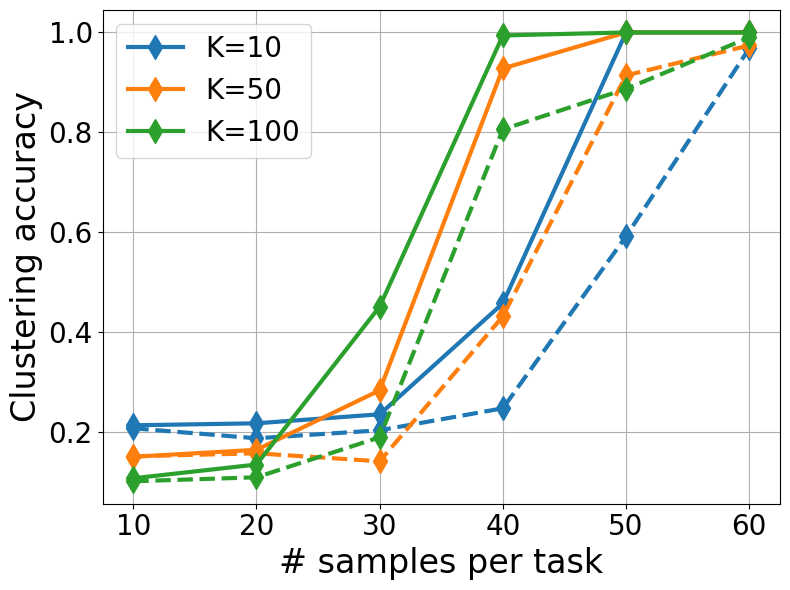

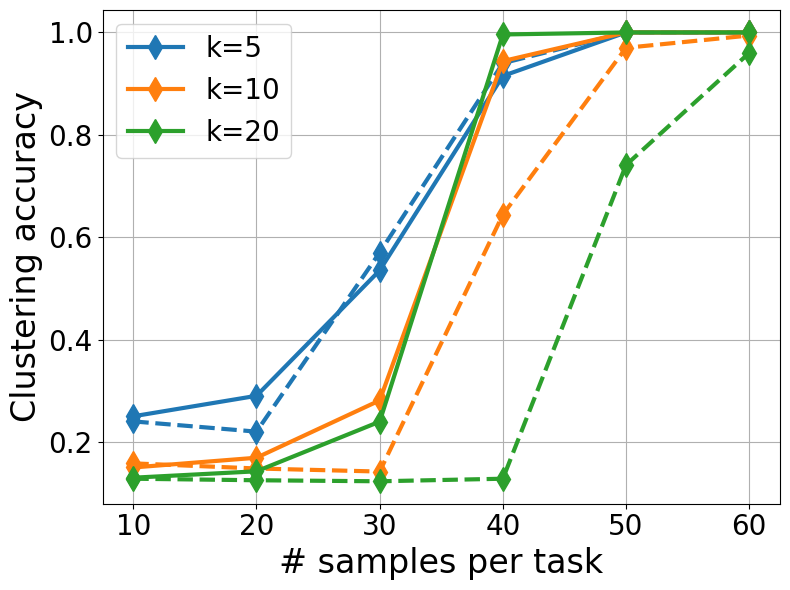

In [31]:
mrk=['s','o','d']
labels=[f'K={Ks[0]}',f'K={Ks[1]}',f'K={Ks[2]}']
ls=[]
plt.figure(figsize=(8,6))
ax = plt.gca()
# ns = ns[:8]
idx = 6
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ns[:idx], quant(acc_k[:,:,i,0],0.5)[:idx],'--d',linewidth=3,markersize=12,color=color)
    plt.plot(ns[:idx], quant(acc_k_shared[:,:,i,0],0.5)[:idx],'-d',linewidth=3,markersize=12,color=color,label=labels[i])
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Clustering accuracy',fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('clusterring_sample_per_pytorch.pdf')

mrk=['s','o','d']
labels=[f'k={ks[0]}',f'k={ks[1]}',f'k={ks[2]}']
ls=[]
plt.figure(figsize=(8,6))
ax = plt.gca()
# ns = ns[:8]
# idx = 6
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ns[:idx], quant(acc_K[:,:,i,0],0.5)[:idx],'--d',linewidth=3,markersize=12,color=color)
    plt.plot(ns[:idx], quant(acc_K_shared[:,:,i,0],0.5)[:idx],'-d',linewidth=3,markersize=12,color=color,label=labels[i])
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Clustering accuracy',fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('clusterring_sample_per_pytorch.pdf')

In [18]:
mrk=['s','o','d']
labels=['MTL','Cluster-MTL','Multipath-MTL']
labels2=['Oracle','Random']
ls=[]
plt.figure(figsize=(8,6))
ax = plt.gca()
# ns = ns[:8]
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    l,=plt.semilogy(ns,quant(ERRn[:,:,0,1,i],0.5),'-'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
    ls.append(l)
    # plt.semilogy(ns,quant(ERRn[:,:,0,0,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
    if i >0:
        s1,=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
        s2,=plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
    # if i == 2:
    #     s1=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
    #     plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
    plt.fill_between(ns,quant(ERRn[:,:,0,1,i],0.25),quant(ERRn[:,:,0,1,i],0.75),alpha=0.25)
plt.ylim([0.002,1])
# plt.xlim([0,20])
# plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
legend1=plt.legend([s1,s2],labels2,fontsize=20,loc='center left')
plt.legend(ls,labels,fontsize=20)
# plt.gca().add_artist(legend1)
# plt.legend(labels2,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Test risk',fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('clusterring_sample_per_pytorch.pdf')

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# for i in range(3):
#     color = next(ax._get_lines.prop_cycler)['color']
#     l,=plt.semilogy(ks,quant(ERRk[:,:,0,1,i],0.5),'-'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
#     ls.append(l)
#     # plt.semilogy(ns,quant(ERRn[:,:,0,0,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
#     if i >0:
#         s1,=plt.semilogy(ks,quant(ERRk[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
#         s2,=plt.semilogy(ks,quant(ERRk[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
#     # if i == 2:
#     #     s1=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
#     #     plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
#     plt.fill_between(ks,quant(ERRk[:,:,0,1,i],0.25),quant(ERRk[:,:,0,1,i],0.75),alpha=0.25)
# # plt.ylim([0.002,1])
# # plt.xlim([0,50])
# # plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
# # plt.legend(fontsize=20)
# legend1=plt.legend([s1,s2],labels2,fontsize=20,loc='center left')
# plt.legend(ls,labels,fontsize=20)
# plt.gca().add_artist(legend1)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# tasks per cluster',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# # plt.show()
# plt.savefig(f'clustering_task_per_cluster_{ITN}runs.pdf')

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# for i in range(3):
#     color = next(ax._get_lines.prop_cycler)['color']
#     q=quant(ERRK[:,:,0,1,i],0.5); q2=q.copy()
#     q_=quant(ERRK[:,:,1,1,i],0.5); q2_=q_.copy()
#     #if i==1: q2[:1]=np.array([0.192])
#     plt.semilogy(Ks,q2,mrk[i]+'-',linewidth=4,markersize=12,color=color,label=labels[i])
#     plt.semilogy(Ks,q2_,mrk[i]+'--',linewidth=4,markersize=12,color=color)
#     plt.fill_between(Ks,quant(ERRK[:,:,0,1,i],0.25)+q2-q,quant(ERRK[:,:,0,1,i],0.75)+q2-q,alpha=0.25)
# # plt.ylim([0.002,1])
# # plt.xlim([0,150])
# # plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
# plt.legend(fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# clusters',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# # plt.savefig('cluster_fig.pdf')

NameError: name 'ERRn' is not defined